# Analyze articles on Hacker News using NLP!

## 1. Introduction

This notebook demonstrates the usage of the [`news-analyze`](https://github.com/jayantj/news-analyze) library, which makes use of topic modeling and clustering for extracting topics and themes out of a corpus of news articles. The key features are - 

1. Extracting high quality, human-interpretable topics from a collection of articles
2. Visualizations of trends in topics over time
3. Automatically ranking topics by "interesting-ness"
4. Clustering topics into groups of related topics
5. Auto-tagging new unseen articles with topics

The goal of the library is to provide a way to qualitatively explore topics and trends in a news corpus to gain insight into it.

The notebook presents the usage of these features using a model trained on an year's worth of Hacker News data, which is present in the repo and directly usable. The library doesn't yet provide a documented API to be able to train new models on your own data. This is a work in progress.

This library was one of the things I worked on while I was part of the [Recurse Center](https://www.recurse.com/), a programmer's retreat for people from a variety of backgrounds and experience levels looking to get better at programming. You should check them out!

A significant motivation behind this initial alpha release and demo is to get feedback about the following - 

1. Specific application and areas where this could be useful
2. Other datasets on which the library could be used
3. New features that could be helpful
4. Problems with existing features
5. Improvements to the API and usage docs


## 2. Data and preprocessing

The data used for training the model is a collection of posts on [Hacker News](http://news.ycombinator.com/), available [here](https://www.kaggle.com/hacker-news/hacker-news-posts/data). The raw data contains 293119 posts from September 2015 to September 2016. A post here refers to an article that was posted to Hacker News, not the comments. The article text is not included, only the url, along with some metadata (time of post, number of points and comments received).

Firstly, any articles that received under 50 points were filtered out, in order to focus on links that received a fair amount of attention on HN, which results in 20148 posts. Next, to extract the full text of these articles, the content from the urls was scraped and parsed using [newspaper](https://github.com/codelucas/newspaper), a Python library which allows extracting of full text of news articles from html. Content from some urls could not be extracted correctly in this process (mostly 404s), resulting in 15016 parsed articles.

Topic models were trained on these using [Gensim](http://github.com/RaRe-Technologies/gensim), a Python library that has both native implementations of various topic modeling algorithms as well as wrappers to external topic modeling frameworks. The final model in the repository was trained using a wrapper to [Mallet](https://github.com/mimno/Mallet). [Spacy](https://github.com/explosion/spaCy) was used for tokenization and lemmatization. Tokens that were extremely frequent or extremely rare were filtered out. For more specific details, please have a look at [this file](https://github.com/jayantj/news-analyze/blob/master/models/utils.py).

## 3. Demonstration

The insights and use-cases presented in this section are on the dataset described above. I don't yet know how well these techniques can generalize to new datasets, and your mileage may vary. Also, the repository does not contain the original text scraped from the HN posts as these are from a variety of websites, some of which might have terms and conditions that do not permit their data to be publicly released. As a result, the notebook might not be runnable on your local machine. I'm currently looking into how to work around this issue.

### Import required packages

In [1]:
%cd ..

/home/jayant/Projects/recurse/hn_analyze


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pickle

In [4]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [5]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]

### Load trained model

In [15]:
model = pickle.load(open('data/models/hn_ldam_mallet_100t_5a', 'rb'))

### 3.1 Print all topics, ordered by "interesting-ness" scores

This is the list of all topics that were extracted from the corpus, printed in human-readable form. Note that in the underlying model, each topic is a vector of scores over all words in the corpus. Here, only the top 10 words for each topic are displayed, for ease of reading and in order to get a sense of what each topic is about.

The topics are ordered in decreasing order of "interesting-ness", which is described in a [later section](#topic-interestingness) in the notebook.

In [53]:
model.print_topics_table()

   Topic #99      Topic #29      Topic #38      Topic #43      Topic #56      Topic #70   
  ----------     ----------     ----------     ----------     ----------     ----------   
    network         earth        container       quantum        bitcoin          car      
     model          space         docker         theory       transaction      vehicle    
   learning         star            run          physics      blockchain        drive     
    neural         planet         service       particle        network         tesla     
     learn          orbit          image        universe        wright          road      
    machine         moon        application     physicist        block          bike      
     deep           year          deploy          wave         ethereum        driver     
   training         mars          cluster         field          trust          model     
     layer         galaxy         machine         hole         currency       electric    

A topic here is NOT exactly the same as the commonly used interpretation of the word `topic`, it is simply a list of "related words". It is intended to represent a broad theme of interest, and doesn't carry a specific label attached to it.

### 3.2 Find articles for a specific topic

This prints all the articles (along with a snippet of their content) that contained a specific topic, ordered in decreasing order of the topic score for the article, which is a measure of how central the topic was to the article. The top 5 articles are shown here for ease of reading.

In [56]:
model.show_topic_articles(99, top_n=5)

   Topic #99   
  ----------   
    network    
     model     
   learning    
    neural     
     learn     
    machine    
     deep      
   training    
     layer     
     image     


---------------------------------------------------------------------
Article #11052034 - http://www.wildml.com/deep-learning-glossary/
Deep Learning Glossary
Topic score: 0.83

Article text:
 This glossary is work in progress and I am planning to continuously update it. If you find a mistake or think an important term is missing, please let me know in the comments or via email.

Deep Learning terminology can be quite overwhelming to newcomers. This glossary tries to define commonly used terms and link to original references and additional resources to help readers dive deeper into a specific topic.

The boundary between what is Deep Learning vs. “general” Machine Learning termino (...)(trimmed)


---------------------------------------------------------------------
Article #10384279 - http://bl

In [58]:
model.show_topic_articles(44, top_n=5)

   Topic #44   
  ----------   
  government   
    agency     
   security    
      nsa      
 surveillance  
      fbi      
    snowden    
 intelligence  
   document    
  information  


---------------------------------------------------------------------
Article #10304864 - https://edwardsnowden.com/
Edwardsnowden.com
Topic score: 0.78

Article text:
 Who Is Edward Snowden?

Edward Snowden is a 31 year old US citizen, former Intelligence Community officer and whistleblower. The documents he revealed provided a vital public window into the NSA and its international intelligence partners’ secret mass surveillance programs and capabilities. These revelations generated unprecedented attention around the world on privacy intrusions and digital security, leading to a global debate on the issue.

Snowden worked in various roles within the US Intel (...)(trimmed)


---------------------------------------------------------------------
Article #11748746 - http://www.theguardian.com/us-n

### 3.3 Find topics for a given article

### 3.3.1 Article from the corpus

This displays the topics that were extracted from a specific article in the corpus.

In [59]:
model.show_article_topics(10577102)

---------------------------------------------------------------------
Article #10577102 - http://www.nytimes.com/2015/11/17/us/after-paris-attacks-cia-director-rekindles-debate-over-surveillance.html
After Paris Attacks, C.I.A. Director Rekindles Debate Over Surveillance
Article text:
 “As far as I know, there’s no evidence the French lacked some kind of surveillance authority that would have made a difference,” said Jameel Jaffer, deputy legal director of the American Civil Liberties Union. “When we’ve invested new powers in the government in response to events like the Paris attacks, they have often been abused.”

The debate over the proper limits on government dates to the origins of the United States, with periodic overreaching in the name of security being cur (...)(trimmed)


   Topic #44      Topic #67      Topic #69   
 Score (0.32)   Score (0.19)   Score (0.15)  
  ----------     ----------     ----------   
  government         al            story     
    agency          sta

The last topic looks strange here - as it turns out, it is an unintended artifact of the data collection process. The `newspaper` library used to extract text from articles extracts text from some of the advertisements and subscribe buttons for NYTimes articles too. As a result, this set of words co-occurs with each other extremely frequently and co-occurs with other words much less frequently, and hence forms a very natural topic for topic modeling algorithms.

### 3.3.2 Finding topics for a new, unseen article

In [1]:
url = "https://www.ligo.caltech.edu/news/ligo20170927"

In [61]:
model.show_article_topics_from_url(url)

Article: https://www.ligo.caltech.edu/news/ligo20170927
Article text:
 News Release • September 27, 2017

The LIGO Scientific Collaboration and the Virgo collaboration report the first joint detection of gravitational waves with both the LIGO and Virgo detectors. This is the fourth announced detection of a binary black hole system and the first significant gravitational-wave signal recorded by the Virgo detector, and highlights the scientific potential of a three-detector network of gravitational-wave detectors.

The three-detector observation was made on August 14 (...)(trimmed)

Most relevant topics:

   Topic #29      Topic #10      Topic #89   
 Score (0.31)   Score (0.15)   Score (0.13)  
  ----------     ----------     ----------   
     earth          light       university   
     space          laser        research    
     star         electron        science    
    planet          field          paper     
     orbit         energy       researcher   
     moon           h

### 3.4 Plotting topic trends

The popularity of topics can be plotted over time. Some cherrypicking for interesting results - 

In [62]:
iplot(model.topic_trend_plot(11))

   Topic #11   
  ----------   
    flight     
      fly      
      air      
     space     
   aircraft    
    launch     
     plane     
     drone     
     pilot     
    rocket     




The topic contains the words `flight, fly, air, space, aircraft, launch` and sees a huge surge in popularity around March - May 2016. This was the time when SpaceX successfully launched and landed its satellites at sea. And of course, things related to Elon Musk have a tendency to be wildly popular on Hacker News :)

A quick look at the articles for this topic agrees with this hypothesis - 

In [65]:
model.show_topic_articles(11, top_n=5)

   Topic #11   
  ----------   
    flight     
      fly      
      air      
     space     
   aircraft    
    launch     
     plane     
     drone     
     pilot     
    rocket     


---------------------------------------------------------------------
Article #11460935 - http://techcrunch.com/2016/04/08/spacex-just-landed-a-rocket-on-a-drone-ship-for-the-first-time/
SpaceX just landed a rocket on a drone ship for the first time
Topic score: 0.82

Article text:
 At 4:43 pm EST, SpaceX successfully launched their next resupply mission to the International Space Station (ISS). In addition to a seamless launch, SpaceX landed the first stage of their Falcon 9 rocket on an autonomous drone ship for the very first time.

Landing from the chase plane pic.twitter.com/2Q5qCaPq9P — SpaceX (@SpaceX) April 8, 2016

This was SpaceX’s fifth landing attempt on a drone ship — all previous attempts ended in explosions. Although in December of last year, Elon Musk (...)(trimmed)


-----------

In [66]:
iplot(model.topic_trend_plot(35))

   Topic #35   
  ----------   
     image     
      uk       
    london     
    caption    
      mr       
   copyright   
    british    
     japan     
     year      
    people     




This topic looks a little more strange. The words `uk london british people` seem fairly coherent, but the presence of words like `image copyright caption` is rather strange. It turns out to be another artifact of the data collection process - a number of the articles with the words `uk London british people` are from the BBC, and the text parser from the article picks up image captions from the BBC site which contain the words `image caption copyright` very frequently.

As for the popularity trend for the topic, the topic seems fairly dormant most of the time, seeing a massive spike in around June 2016. No prizes for guessing what this is due to - 

In [73]:
model.show_topic_articles(35, top_n=5)

   Topic #35   
  ----------   
     image     
      uk       
    london     
    caption    
      mr       
   copyright   
    british    
     japan     
     year      
    people     


---------------------------------------------------------------------
Article #11970960 - http://www.bbc.com/news/uk-politics-eu-referendum-36620401
Petition for London independence signed by thousands after Brexit vote
Topic score: 0.67

Article text:
 Image copyright Reuters Image caption The overwhelming majority of Londoners voted to remain in the EU

A petition calling for Sadiq Khan to declare London an independent state after the UK voted to quit the EU has been signed by thousands of people.

The petition's organiser James O'Malley, said the capital was "a world city" which should "remain at the heart of Europe".

Nearly 60% of people in the capital backed the Remain campaign, in stark contrast to most of the country.

The LSE's directo (...)(trimmed)


----------------------------------

In [69]:
iplot(model.topic_trend_plot(44))

   Topic #44   
  ----------   
  government   
    agency     
   security    
      nsa      
 surveillance  
      fbi      
    snowden    
 intelligence  
   document    
  information  




This topic has a more interesting trend. Privacy and government surveillance has long been a popular topic on Hacker News, and this is clear from the relatively high popularity values in comparison to the other topics plotted so far. As for the significant increase in popularity around February 2016, this corresponds to the San Bernardino event, when there was a large amount of debate on privacy and surveillance, centered around whether Apple, under pressure by the FBI, should or should not unlock an iPhone used by one of the shooters.

There are also numerous other spikes in this graph, and it'd be interesting to look at them in more detail to see if they can be traced to specific events.

### 3.5 Topic Intersection

Topics can be combined to find articles that are relevant to both topics. Here, we see combining two separate topics consisting of the words `game player play move win` and `google computer technology machine human` give us articles related to AlphaGo's success against the human Go champion, Lee Sedol.

In [26]:
model.show_topic_articles([65, 66], top_n=5)

   Topic #65      Topic #66   
  ----------     ----------   
     game          google     
    player        computer    
     play        technology   
     move          machine    
      win           human     
     world         system     
     chess          world     
   computer          ai       
     level          year      
     sport          robot     


---------------------------------------------------------------------
Article #11250871 - http://googleasiapacific.blogspot.com/2016/03/alphagos-ultimate-challenge.html
AlphaGos ultimate challenge: a five-game match against Lee Sedol
Topic score: 0.35

Article text:
 Game 3 - March 12, 2016

“It’s arguable that in the first two games Lee Sedol was playing differently than his true style, trying to find a weakness in the computer. Today Lee was definitely playing his own game, from his strong opening to the complicated moves in the final kō. AlphaGo was ready for everything, including the kō fights, and was able to take

### 3.6 Similar topics

Topics that are similar to a specific topic can be found using - 

In [27]:
model.show_similar_topics(44, top_n=5)

   Topic #44   
  ----------   
  government   
    agency     
   security    
      nsa      
 surveillance  
      fbi      
    snowden    
 intelligence  
   document    
  information  


Topics similar to topic #44
---------------------------

   Topic #73      Topic #3       Topic #98      Topic #50      Topic #67   
 Score (0.23)   Score (0.18)   Score (0.17)   Score (0.16)   Score (0.15)  
  ----------     ----------     ----------     ----------     ----------   
      law           group          datum        security          al       
     court         public          user          attack          state     
     case         political     information   vulnerability     attack     
     legal          state          data          exploit         group     
     rule          member         privacy        hacker       government   
     state         policy         access        password        country    
    lawyer        campaign        service       attacker        i

<a id="topic-interestingness"></a>

### 3.7 Topic Interesting-ness

There are certain topics which occur more frequently in articles than others, but with lower scores. The hypothesis is that these topics are more common and generic, whereas interesting topics would occur less frequently in articles, but higher scores. Common and generic topics would have low scores frequently, indicating they are rarely the main focus of an article, whereas the opposite is true for interesting topics.

Plotting the distribution of scores over all articles for two topics - 

In [76]:
topics_of_interest = [43, 95]

In [75]:
model.print_topics_table(topics_of_interest)

   Topic #43      Topic #95   
  ----------     ----------   
    quantum         test      
    theory          code      
    physics         error     
   particle          bug      
   universe        problem    
   physicist         fix      
     wave           check     
     field          fail      
     hole           issue     
     state           run      




In [83]:
iplot(model.plot_topic_article_distribution(topics_of_interest))

As expected, the histogram for topic #95 (`test, code, error, bug, problem`), a rather generic topic, at least for Hacker News content, is quite skewed to the left, indicating it occurs with low scores very frequently in articles, and almost never with a high score. The histogram for topic #43 (`quantum, theory, physics, particle, universe`) is much flatter, indicating it is the main theme of an article much more often.

Computing the median of scores across all articles seems like a decent mathematical way of capturing this intuition of "interesting-ness". Sorting topics by the computed median scores in decreasing order, we get -

In [84]:
model.print_topics_table()

   Topic #99      Topic #29      Topic #38      Topic #43      Topic #56      Topic #70   
  ----------     ----------     ----------     ----------     ----------     ----------   
    network         earth        container       quantum        bitcoin          car      
     model          space         docker         theory       transaction      vehicle    
   learning         star            run          physics      blockchain        drive     
    neural         planet         service       particle        network         tesla     
     learn          orbit          image        universe        wright          road      
    machine         moon        application     physicist        block          bike      
     deep           year          deploy          wave         ethereum        driver     
   training         mars          cluster         field          trust          model     
     layer         galaxy         machine         hole         currency       electric    

This seems to give reasonably good results. Specific, focused topics are at the top, whereas common generic topics are at the bottom. It is possible that this metric of interesting-ness could be flawed for certain kinds of data, where either the notion of interesting-ness is different in the first place (as it is a subjective notion), or where the topic-article distribution is significantly different.

### 3.8 Topic Clusters

The model has a notion of similarity between topics based on a few metrics. The two basic ideas are -
1. Two topics are similar if they have similar words
2. Two topics are similar if they co-occur frequently in articles

The first captures the notion of lexical similarity, whereas the second captures the notion of relatedness.

Plotting the topic similarity matrix for the `word_doc_sim` metric which combines both (1) and (2) - 

In [86]:
model.plot_topic_similarities(metric='word_doc_sim')

Looking at this matrix, it is possible to discern a couple of patterns -
1. Certain topics are similar to many of the other topics. These stand out as distinctly dark rows/columns in the above matrix.
2. Certain topics are similar to almost none of the other topics - stand-alone topics. These stand out as almost completely white rows/columns in the matrix above.

Both these kind of topics are not well-suited for clustering. Stand-alone topics should be typically be clusters of their own, and it is difficult to assign a single cluster to common topics, as they similar or related to many of the other topics. From a graph-theoretic point of view, these topics would be hub nodes - connected to many of the other topics, and not part of any single graph partition.

So, the method to cluster topics provides options to exclude such topics from the clustering process.

In addition, the model includes an internal method to determine cluster quality based on the [silhouette scores](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) of its constituent nodes. The printed clusters are sorted in decreasing order of cluster quality.

In [34]:
model.cluster_topics(metric='word_doc_sim', exclude_common=True, exclude_standalone=True)

In [35]:
model.print_topic_clusters()

Cluster 1----------------------------------

   Topic #39      Topic #42      Topic #47      Topic #51   
  ----------     ----------     ----------     ----------   
    company        company        product         price     
    startup         year         customer         sell      
    founder       employee       business        company    
   investor        million        service        market     
     tech         business        revenue          buy      
    valley        executive        share        business    
     start         billion        growth         product    
    silicon        accord        platform          pay      
   business         firm          result          cost      
     money           ceo         software         sale      




Cluster 9----------------------------------

   Topic #16      Topic #48      Topic #86   
  ----------     ----------     ----------   
     node         database        service    
    system          query          d

Plotting the similarity matrix for the clustered topics - 

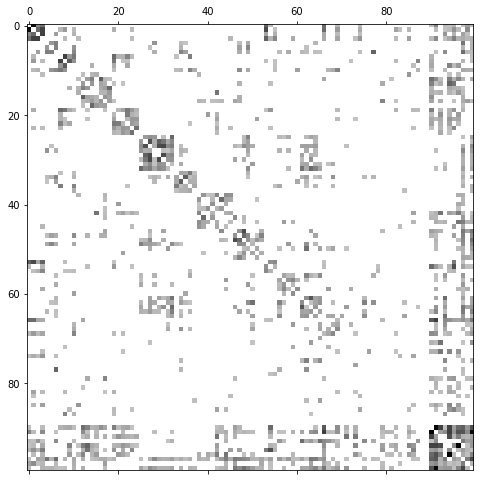

In [107]:
model.plot_clustered_topic_similarities(metric='word_doc_sim', threshold_percentile=85)

The common as well as standalone topics excluded from the clustering are at the end. Also note that the diagonal values (self-similarity) have been zeroed in the matrix above to allow for easier visualization.

A number of the clusters look fairly reasonable, grouping together related topics. However, there is one large cluster at the end which contains a large number of disparate, wide-ranging topics - from the matrix, it is also evident that these topics are not very similar to most of the topics part of clustering.

This suggests that excluding certain topics can introduce certain disadvantages.

There are also some other tricky aspects to clustering topics - 
1. Choosing an appropriate number of clusters
2. Whether clustering topics is even suitable for the kind of data and topics you have
3. How to handle common as well as stand-alone topics while clustering

## 4. Future Steps

1. A clearly defined, well-documented API to allow extracting topics from a user-supplied dataset
2. Interactive visualization that allows users to browse articles and topics in a single graph
3. Extracting topics hierarchically - being able to extract sub-topics from the articles associated with a particular topic in order to focus on a more specific theme of interest
4. Tagging events from news articles to spikes in topic popularity, in order to understand why the interest in a certain topic varied as it did

In conclusion, I'd love to get more feedback about whether and how this could be useful. Please do get in touch at <jayantjain1992@gmail.com> if you have any ideas. Feel free to do so if you wish to talk about NLP generally either!
